In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict as odict
import pandas as pd

Load the SN light curve fits that were generated in [this notebook](https://github.com/djreiss/AnalyzeSN/blob/master/notebooks/LC%20fitting%202.ipynb).

This is an array of "SN fit" objects. An example is printed at the end of this cell:

In [2]:
import sys
import gzip, pickle

if sys.version.startswith('2'):
    snFits = pickle.load(gzip.GzipFile('snFits.p.gz'))
else:
    snFits = pickle.load(gzip.GzipFile('snFits.p.gz'),
                     encoding='latin1')
print(len(snFits))
snf = [s for s in snFits.values() if s is not None]
print(len(snf))
snf[0]

1622
1549


z                                                       0.870895
t0                                                       51536.4
x0                                                        242194
x1                                                        112109
c                                                       -2.75795
hostebv                                                        0
hostr_v                                                      3.1
mwebv                                                          0
mwr_v                                                        3.1
mu                                                       15690.4
mu_var                                                   6.20631
inputParams    {'t0': 51389.9, 'x0': 2.52675e-06, 'x1': -0.31...
dtype: object

Use list comprehension to extract the redshift (`z`) and fitted distance modulus (`mu`) from each of the supernova light curve fits. Each of those becomes its own array of numbers.

Also extract `mu_var`. Need to do this in a loop since for some light curve fits `mu_var` doesn't exist (for a reason that I am not sure of right now).

In [3]:
z = np.array([s.z for s in snf])
mu = np.array([s.mu for s in snf])

mu_var = mu.copy() #np.array([s.mu_var for s in snf])
for i,s in enumerate(snf):
    try:
        mu_var[i] = s.mu_var
    except:
        mu_var[i] = 999

# Here, we didn't fit z so zz and z will be identical.
zz = z.copy() #np.array([s['inputParams'].get('z') for s in snf]) 
for i,s in enumerate(snf):
    try:
        zz[i] = s['inputParams'].get('z')
    except:
        zz[i] = 999

Filter the data to remove points that are probably way wrong (e.g. too high or too low `mu`).

TODO: we need to look at some of these bad points and understand why their fits gave incorrect results.

In [4]:
z = z[(mu > 0) & (mu < 19)]
zz = zz[(mu > 0) & (mu < 19)]
mu = mu[(mu > 0) & (mu < 19)]
mu_var = mu_var[(mu > 0) & (mu < 19)]

/Users/meramanjar/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1549 but corresponding boolean dimension is 1439


Plot the Hubble diagram.

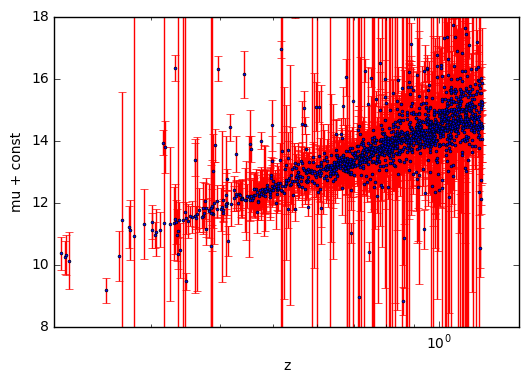

In [5]:
#plt.scatter(z, mu)
plt.errorbar(z, mu, yerr=np.sqrt(mu_var), fmt='o', ecolor='r', elinewidth=1, ms=2)
plt.xlabel('z')
plt.xscale('log')
plt.ylabel('mu + const')
plt.xlim((0.2,1.4))
plt.ylim((8,18));

The `mu`s computed above are offset by some constant that we do not know yet. Let's estimate that offset by computing a Hubble diagram for a model cosmology.

In [6]:
from astropy.cosmology import Planck15 as cosmo
mu = np.array([s.mu for s in snf])
x0 = np.array([s.x0 for s in snf])
x0 = x0[(mu > 0) & (mu < 19)]
x1 = np.array([s.x1 for s in snf])
x1 = x1[(mu > 0) & (mu < 19)]
c = np.array([s.c for s in snf])
c = c[(mu > 0) & (mu < 19)]
mu = mu[(mu > 0) & (mu < 19)]
muz = np.array(cosmo.distmod(z))

alpha = 0.14
beta = -3.11
M = -2.5 * np.log10(x0) + alpha * x1 + beta * c - muz
# plt.scatter(z, muz)
# plt.xlabel('z')
# plt.xscale('log')
# plt.xlim((0.2,1.4))
# plt.ylabel('mu')
# plt.ylim((39,45));

Compute the constant offset as the median of the differences between the cosmological `mu` and the fitted SN `mu`.

29.7558162588


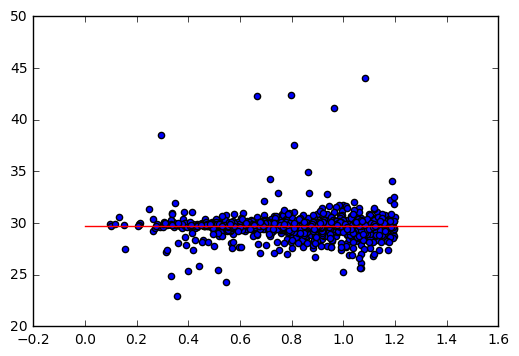

In [7]:
const = np.median(muz-mu)
print(const)
plt.scatter(z,muz-mu)
plt.plot([0,1.4],[const,const],'r')

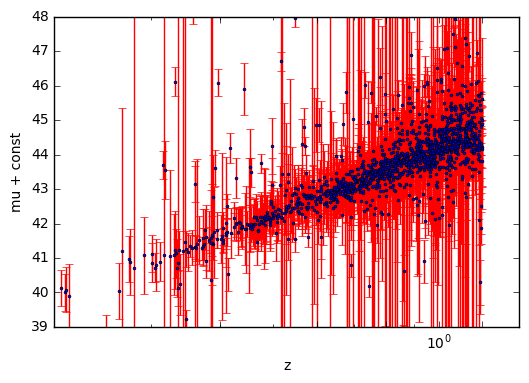

In [8]:
plt.errorbar(z, mu+const, yerr=np.sqrt(mu_var), fmt='o', ecolor='r', elinewidth=1, ms=2)
plt.xlabel('z')
plt.xscale('log')
plt.ylabel('mu + const')
plt.xlim((0.2,1.4))
plt.xticks(np.arange(0.2,1.4,0.2))
plt.ylim((39,48));

In [9]:

help (np.histogram)

Help on function histogram in module numpy.lib.function_base:

histogram(a, bins=10, range=None, normed=False, weights=None, density=None)
    Compute the histogram of a set of data.
    
    Parameters
    ----------
    a : array_like
        Input data. The histogram is computed over the flattened array.
    bins : int or sequence of scalars or str, optional
        If `bins` is an int, it defines the number of equal-width
        bins in the given range (10, by default). If `bins` is a
        sequence, it defines the bin edges, including the rightmost
        edge, allowing for non-uniform bin widths.
    
        .. versionadded:: 1.11.0
    
        If `bins` is a string from the list below, `histogram` will use
        the method chosen to calculate the optimal bin width and
        consequently the number of bins (see `Notes` for more detail on
        the estimators) from the data that falls within the requested
        range. While the bin width will be optimal for the actua

In [10]:
hist , edges = np.histogram(z, bins =10)

In [11]:
edges

array([ 0.0965254 ,  0.20671712,  0.31690884,  0.42710055,  0.53729227,
        0.64748399,  0.75767571,  0.86786743,  0.97805914,  1.08825086,
        1.19844258])

In [12]:
hist

array([  7,  18,  64,  96, 119, 191, 229, 245, 266, 204])

In [13]:
print(len (edges))
print(len (hist))

11
10


In [14]:
mid_pts =[]
for ii in range(len(edges)-1):
    mid_pts.append(0.5*(edges[ii]+edges[ii+1]))
print(mid_pts)
    

[0.1516212597489357, 0.2618129774928093, 0.37200469523668289, 0.48219641298055649, 0.59238813072443008, 0.70257984846830368, 0.81277156621217728, 0.92296328395605087, 1.0331550016999245, 1.1433467194437981]


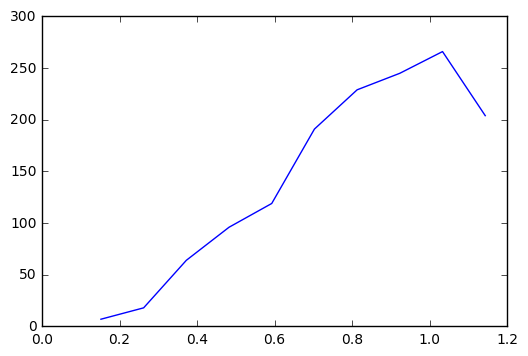

In [15]:

plt.plot (mid_pts, hist)

In [16]:
help(np.random.choice)

Help on built-in function choice:

choice(...) method of mtrand.RandomState instance
    choice(a, size=None, replace=True, p=None)
    
    Generates a random sample from a given 1-D array
    
            .. versionadded:: 1.7.0
    
    Parameters
    -----------
    a : 1-D array-like or int
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated as if a was np.arange(n)
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    replace : boolean, optional
        Whether the sample is with or without replacement
    p : 1-D array-like, optional
        The probabilities associated with each entry in a.
        If not given the sample assumes a uniform distribution over all
        entries in a.
    
    Returns
    --------
    samples : 1-D ndarray, s

np.random.choice(binz, 1000, p= #generate a random set of supernovae and see if we an get a different set of random z values and see if we can get them to look the same) # number of supernova in the bin vs total number of supernova 

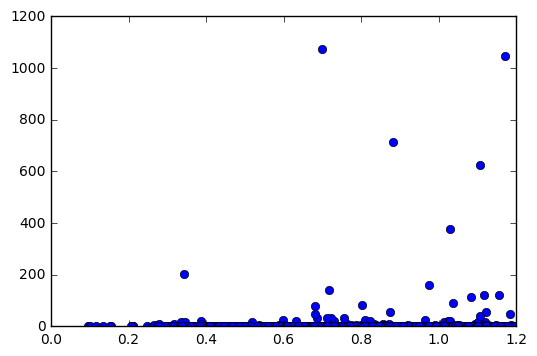

In [17]:
plt.plot(z, np.sqrt(mu_var), 'o') 

In [18]:
import pandas as pd 

In [19]:
df = pd.dataFrame(gzip.GzipFile('snFits.p.gz'),
                     encoding='latin1')

AttributeError: module 'pandas' has no attribute 'dataFrame'

In [ ]:
type (snFits)

In [20]:
df = pd.DataFrame(snFits)

In [21]:
df.head()

,10005,10018,10024,10034,10059,10087,10092,10135,10136,1014,...,9875,9893,9906,9919,9940,9956,9966,9996,9997,9998
c,-0.121929,None,0.136068,0.0450403,-0.313476,0.0462698,0.0988343,-0.0298518,0.0776311,-0.00395545,...,0.151322,0.0332876,0.0601968,-0.064084,-0.0992085,0.168553,0.224081,-0.0279898,-0.0690699,0.554351
hostebv,0,None,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hostr_v,3.1,None,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,...,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1,3.1
inputParams,"{'t0': 51366.4, 'x0': 2.33246e-06, 'x1': 0.316...",None,"{'t0': 49526.4, 'x0': 1.89643e-06, 'x1': -0.00...","{'t0': 49797.0, 'x0': 3.91948e-06, 'x1': 1.333...","{'t0': 52299.5, 'x0': 7.96518e-07, 'x1': -2.15...","{'t0': 51916.5, 'x0': 1.34099e-06, 'x1': -1.35...","{'t0': 51660.8, 'x0': 2.02691e-05, 'x1': 0.810...","{'t0': 52956.2, 'x0': 1.50645e-06, 'x1': -0.17...","{'t0': 51869.1, 'x0': 2.08861e-06, 'x1': -0.03...","{'t0': 52625.4, 'x0': 1.57086e-05, 'x1': -0.05...",...,"{'t0': 50537.5, 'x0': 1.49797e-06, 'x1': 0.749...","{'t0': 50317.4, 'x0': 5.31459e-06, 'x1': 0.939...","{'t0': 50247.6, 'x0': 8.27902e-06, 'x1': 1.859...","{'t0': 52795.5, 'x0': 5.27805e-06, 'x1': -0.88...","{'t0': 52282.4, 'x0': 1.59866e-05, 'x1': 0.300...","{'t0': 51434.1, 'x0': 1.5377e-06, 'x1': -2.071...","{'t0': 49728.8, 'x0': 3.29583e-06, 'x1': 1.077...","{'t0': 51182.1, 'x0': 6.8868e-06, 'x1': 1.9237...","{'t0': 51692.7, 'x0': 2.44391e-06, 'x1': -0.47...","{'t0': 52220.0, 'x0': 3.92665e-05, 'x1': -0.11..."
mu,14.4485,None,14.6638,14.293,15.3082,14.3719,18.5476,14.7065,13.6749,11.9806,...,17.3679,13.2705,12.6044,13.1048,12.4316,13.7975,13.3523,13.3476,14.0323,2.41581


In [22]:
snf = [s for s in snFits.values() if s is not None]

In [23]:
len(snf)

1549

In [24]:
snFits['18263']

z                                                       0.893399
t0                                                       51460.8
x0                                                   1.76928e-06
x1                                                       9.00393
c                                                       0.131314
hostebv                                                        0
hostr_v                                                      3.1
mwebv                                                          0
mwr_v                                                        3.1
mu                                                       15.2327
mu_var                                                  0.686219
inputParams    {'t0': 51470.0, 'x0': 2.28846e-06, 'x1': 1.749...
dtype: object

In [25]:
df = df.transpose() 

In [26]:
results = df[['mu', 'mu_var', 'z']].astype(np.float)
results.head()

,mu,mu_var,z
10005,14.448511,0.253021,0.968958
10018,NaN,NaN,NaN
10024,14.663764,0.276984,0.861278
10034,14.292957,0.301233,0.820012
10059,15.308183,0.537081,1.040996


In [27]:
results.dtypes

mu        float64
mu_var    float64
z         float64
dtype: object

In [28]:
lowz = results.query('z < .4')
lowz.head()


,mu,mu_var,z
10092,18.547567,1.888219,0.357580
1094,11.588167,0.089055,0.353296
11421,11.091647,0.137547,0.335215
11606,11.221315,0.112485,0.272933
11835,11.540782,0.081636,0.356288


(array([ 0.14991376,  0.00416427,  0.        ,  0.        ,  0.00208214,
         0.        ,  0.        ,  0.        ,  0.        ,  0.00208214]),
 array([  5.98068513e-02,   6.37922944e+00,   1.26986520e+01,
          1.90180746e+01,   2.53374972e+01,   3.16569198e+01,
          3.79763424e+01,   4.42957650e+01,   5.06151876e+01,
          5.69346102e+01,   6.32540328e+01]),
 <a list of 10 Patch objects>)

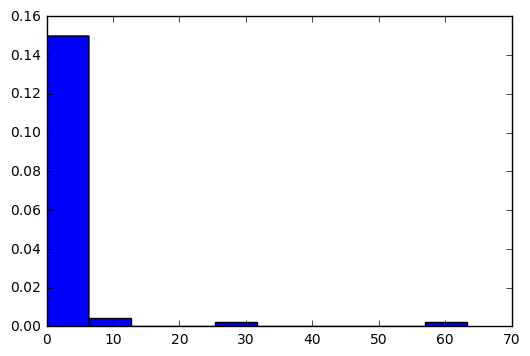

In [29]:
plt.hist(lowz['mu_var'], normed=1)

In [30]:
plt.hist (highz['mu_var'],normed=1 )

NameError: name 'highz' is not defined

In [31]:
results['bindex'] = results['z'] // 0.1

In [32]:
results.head()

,mu,mu_var,z,bindex
10005,14.448511,0.253021,0.968958,9.0
10018,NaN,NaN,NaN,NaN
10024,14.663764,0.276984,0.861278,8.0
10034,14.292957,0.301233,0.820012,8.0
10059,15.308183,0.537081,1.040996,10.0


In [33]:
results['mu_err'] = np.sqrt(results['mu_var']) 
results.head()


,mu,mu_var,z,bindex,mu_err
10005,14.448511,0.253021,0.968958,9.0,0.503012
10018,NaN,NaN,NaN,NaN,NaN
10024,14.663764,0.276984,0.861278,8.0,0.526293
10034,14.292957,0.301233,0.820012,8.0,0.548847
10059,15.308183,0.537081,1.040996,10.0,0.732858


In [34]:
results.dtypes

mu        float64
mu_var    float64
z         float64
bindex    float64
mu_err    float64
dtype: object

In [35]:
grouped = results.groupby('bindex')

In [36]:
help(.agg)

SyntaxError: invalid syntax (<ipython-input-36-1014dbcc6bd8>, line 1)

mu_error= np.sqrt(mu_var)

In [37]:
def clipped_mean(mu_err, outlier_threshhold):
    return(mu_err[mu_err< outlier_threshhold])

In [38]:
mu_err_table = grouped.agg(dict(mu_err=[np.mean, np.std, "count"]))
mu_err_table

mu_err                 
             mean        std count
bindex                            
0.0      0.373468        NaN     1
1.0      1.103441   1.207650     6
2.0      1.307009   2.087522    14
3.0      0.570498   0.768157    55
4.0      6.898620  40.848421    89
5.0      2.104664   9.440305   108
6.0      0.719500   1.612042   152
7.0      5.152529  44.701225   206
8.0     10.158995  86.077829   228
9.0      1.476631   5.805465   236
10.0     2.408266  14.723936   257
11.0     7.374892  75.816557   195

In [39]:
mu_err_table.mu_err['count'].sum()

1547

In [40]:
def numinbins(tab, NumSN):
    x = (tab.mu_err['count']/tab.mu_err['count'].sum())
    return(round(x*NumSN).astype(np.int))

In [51]:
numinbins(mu_err_table, 2000)

bindex
0.0       1
1.0       8
2.0      18
3.0      71
4.0     115
5.0     140
6.0     197
7.0     266
8.0     295
9.0     305
10.0    332
11.0    252
Name: count, dtype: int64

In [42]:
#write muerr 
#loop through each bin and take the number we get from num in bins and then 
#np.random.normal(mean,std, size)


In [47]:
def muerr(tab, NumSN):
    return np.random.normal(tab.mu_err['mean'], tab.mu_err ['std'])
muerr(mu_err_table, 1000)


array([          nan,    1.70852622,    5.24375982,   -0.27541247,
         71.95687736,  -10.37423429,    0.85187166,  -51.79287987,
        142.53893397,    1.90322611,   -6.8915982 ,   37.68158818])

In [52]:
mu_err_table['frequencies']= mu_err_table.mu_err['count']/mu_err_table.mu_err['count'].sum()

In [69]:
mu_err_table= mu_err_table.ix[1:]

In [70]:
mu_err_table

mu_err                  frequencies
             mean        std count            
bindex                                        
1.0      1.103441   1.207650     6    0.003878
2.0      1.307009   2.087522    14    0.009050
3.0      0.570498   0.768157    55    0.035553
4.0      6.898620  40.848421    89    0.057531
5.0      2.104664   9.440305   108    0.069813
6.0      0.719500   1.612042   152    0.098255
7.0      5.152529  44.701225   206    0.133161
8.0     10.158995  86.077829   228    0.147382
9.0      1.476631   5.805465   236    0.152553
10.0     2.408266  14.723936   257    0.166128
11.0     7.374892  75.816557   195    0.126050

mu_err_table

In [100]:
NumSN= 50000
numObjectsPerBin = np.round(mu_err_table.frequencies * NumSN).astype(np.int)
print(numObjectsPerBin)

bindex
1.0      194
2.0      452
3.0     1778
4.0     2877
5.0     3491
6.0     4913
7.0     6658
8.0     7369
9.0     7628
10.0    8306
11.0    6303
Name: frequencies, dtype: int64


In [78]:
m, s  = [mu_err_table.mu_err['mean'], mu_err_table.mu_err['std']] # Now the mean of the 0th bin is assigned to m, and std to s
#X = np.random.normal(m, s, size=numObjectsPerBin.ix[1] )
#print()


In [79]:
m

bindex
1.0      1.103441
2.0      1.307009
3.0      0.570498
4.0      6.898620
5.0      2.104664
6.0      0.719500
7.0      5.152529
8.0     10.158995
9.0      1.476631
10.0     2.408266
11.0     7.374892
Name: mean, dtype: float64

In [80]:
s

bindex
1.0      1.207650
2.0      2.087522
3.0      0.768157
4.0     40.848421
5.0      9.440305
6.0      1.612042
7.0     44.701225
8.0     86.077829
9.0      5.805465
10.0    14.723936
11.0    75.816557
Name: std, dtype: float64

In [87]:
numObjectsPerBin

bindex
1.0      194
2.0      452
3.0     1778
4.0     2877
5.0     3491
6.0     4913
7.0     6658
8.0     7369
9.0     7628
10.0    8306
11.0    6303
Name: frequencies, dtype: int64

In [134]:
X = [np.random.normal(m[i], s[i], size=numObjectsPerBin[i]) for i in range(1, len(numObjectsPerBin))]

In [135]:
X[0]

array([ 0.91941205,  1.76466685,  1.79642477,  2.24608513, -1.20968645,
        0.71445211,  1.34014932,  3.04591093,  1.08341817,  0.47791657,
        0.66347232, -0.21995493,  1.74907226,  0.71856483,  3.87252269,
        0.65245052,  1.28400697,  2.21388052, -0.07750609, -0.75914447,
       -1.25930482,  2.76122054,  0.86582104,  1.60613476, -1.0934847 ,
        1.44614086,  1.11597078,  0.80973891,  2.65808119,  0.52027908,
       -0.40061102,  1.432127  , -0.21343925,  3.06297737,  2.81787563,
        0.8494697 ,  2.59530725,  0.25713775,  1.88944041,  2.76106885,
        2.62599904,  2.5123945 ,  3.16984068,  2.6632955 , -0.49352696,
        2.15644649, -0.07426677,  2.13256517,  1.09974114,  0.5724119 ,
        0.08107513,  2.76831196,  1.19551538,  3.45336932,  1.47261591,
        1.56467441,  0.52669013,  0.58153201,  3.3127229 ,  1.95425121,
        1.33633091,  1.43214632,  1.61035914,  0.43423544,  3.26385879,
        0.09448501,  1.10261395,  2.07225217,  3.19495831,  1.21

In [90]:
len(X[0])

194

In [91]:
np.mean(X[0])

0.96058491273073876

In [92]:
np.mean(X[3])

6.1146482875655028

In [133]:
len(X)#x=xvals

0

In [94]:
type(X)

list

In [97]:
x=np.array(list(map(len, X)))
y =np.float(sum(list(map(len,X))))

In [103]:
z= np.random.uniform(0,.1, size = NumSN)
len(z)

50000

(array([ 4962.,  5014.,  5073.,  5034.,  4998.,  5063.,  5087.,  4815.,
         4953.,  5001.]),
 array([  4.06536406e-07,   9.99970163e-03,   1.99989967e-02,
          2.99982918e-02,   3.99975869e-02,   4.99968820e-02,
          5.99961771e-02,   6.99954722e-02,   7.99947673e-02,
          8.99940624e-02,   9.99933575e-02]),
 <a list of 10 Patch objects>)

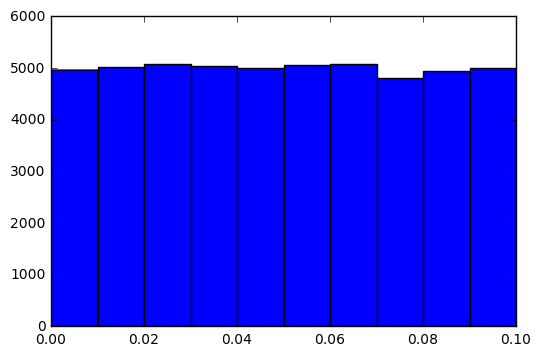

In [104]:
plt.hist(z)

In [105]:
numObjectsPerBin

bindex
1.0      194
2.0      452
3.0     1778
4.0     2877
5.0     3491
6.0     4913
7.0     6658
8.0     7369
9.0     7628
10.0    8306
11.0    6303
Name: frequencies, dtype: int64

In [112]:
z[:numObjectsPerBin.values[0]]

array([ 0.08658805,  0.09589284,  0.06418976,  0.00047568,  0.09157449,
        0.09172002,  0.09022202,  0.07924673,  0.04364696,  0.04897759,
        0.09991632,  0.0483836 ,  0.07928154,  0.0249631 ,  0.05947558,
        0.07984461,  0.00419341,  0.09889894,  0.02272453,  0.02848394,
        0.06447084,  0.0926921 ,  0.0039041 ,  0.01029939,  0.05336204,
        0.02512074,  0.00786662,  0.01069563,  0.03168631,  0.00325858,
        0.0112379 ,  0.03437233,  0.07152171,  0.07665175,  0.03130638,
        0.04732847,  0.02397473,  0.07256247,  0.04151408,  0.05253412,
        0.03850797,  0.0950497 ,  0.09819488,  0.02980222,  0.04254983,
        0.00607425,  0.04284813,  0.04960068,  0.09351136,  0.0517872 ,
        0.05484294,  0.0254873 ,  0.00154036,  0.09498638,  0.07044467,
        0.04755441,  0.01744777,  0.09714333,  0.05893229,  0.06346481,
        0.08189448,  0.0177548 ,  0.00250163,  0.05458538,  0.08113833,
        0.06654087,  0.07643926,  0.05430484,  0.0221521 ,  0.06

In [113]:
z[:numObjectsPerBin.values[i]]

array([ 0.08658805,  0.09589284,  0.06418976,  0.00047568,  0.09157449,
        0.09172002,  0.09022202,  0.07924673,  0.04364696,  0.04897759,
        0.09991632,  0.0483836 ,  0.07928154,  0.0249631 ,  0.05947558,
        0.07984461,  0.00419341,  0.09889894,  0.02272453,  0.02848394,
        0.06447084,  0.0926921 ,  0.0039041 ,  0.01029939,  0.05336204,
        0.02512074,  0.00786662,  0.01069563,  0.03168631,  0.00325858,
        0.0112379 ,  0.03437233,  0.07152171,  0.07665175,  0.03130638,
        0.04732847,  0.02397473,  0.07256247,  0.04151408,  0.05253412,
        0.03850797,  0.0950497 ,  0.09819488,  0.02980222,  0.04254983,
        0.00607425,  0.04284813,  0.04960068,  0.09351136,  0.0517872 ,
        0.05484294,  0.0254873 ,  0.00154036,  0.09498638,  0.07044467,
        0.04755441,  0.01744777,  0.09714333,  0.05893229,  0.06346481,
        0.08189448,  0.0177548 ,  0.00250163,  0.05458538,  0.08113833,
        0.06654087,  0.07643926,  0.05430484,  0.0221521 ,  0.06

In [116]:
for i in range (len(numObjectsPerBin)):
    z[:numObjectsPerBin.values[i]]+= .1

(array([ 41694.,    678.,    259.,    711.,    355.,   1390.,   1422.,
           614.,   1099.,   1326.,    258.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1]),
 <a list of 11 Patch objects>)

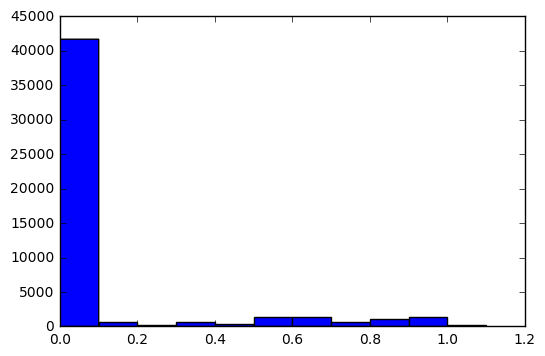

In [121]:
plt.hist(z, bins= np.arange(0,1.2,.1))


In [122]:
z[10:]

array([ 1.29991632,  1.1483836 ,  1.17928154, ...,  0.05068257,
        0.02401961,  0.06554794])

In [123]:
z

array([ 1.28658805,  1.29589284,  1.26418976, ...,  0.05068257,
        0.02401961,  0.06554794])

In [127]:
from astropy.cosmology import Planck15

In [128]:
Planck15.distmod(z).value

array([ 44.834961  ,  44.85426078,  44.78791994, ...,  36.83562208,
        35.17206872,  37.41688772])

In [136]:
X

[array([ 0.91941205,  1.76466685,  1.79642477,  2.24608513, -1.20968645,
         0.71445211,  1.34014932,  3.04591093,  1.08341817,  0.47791657,
         0.66347232, -0.21995493,  1.74907226,  0.71856483,  3.87252269,
         0.65245052,  1.28400697,  2.21388052, -0.07750609, -0.75914447,
        -1.25930482,  2.76122054,  0.86582104,  1.60613476, -1.0934847 ,
         1.44614086,  1.11597078,  0.80973891,  2.65808119,  0.52027908,
        -0.40061102,  1.432127  , -0.21343925,  3.06297737,  2.81787563,
         0.8494697 ,  2.59530725,  0.25713775,  1.88944041,  2.76106885,
         2.62599904,  2.5123945 ,  3.16984068,  2.6632955 , -0.49352696,
         2.15644649, -0.07426677,  2.13256517,  1.09974114,  0.5724119 ,
         0.08107513,  2.76831196,  1.19551538,  3.45336932,  1.47261591,
         1.56467441,  0.52669013,  0.58153201,  3.3127229 ,  1.95425121,
         1.33633091,  1.43214632,  1.61035914,  0.43423544,  3.26385879,
         0.09448501,  1.10261395,  2.07225217,  3.1